### This notebook will walk you through how to build a lipid bilayer, starting from any arbitrary smiles string using OpenFF's interchange

Import all dependencies 

In [1]:
from io import StringIO
from typing import Iterable
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
import MDAnalysis as mda
from MDAnalysis.analysis import distances
from openff.toolkit import ForceField, Molecule, Topology
from openff.toolkit.utils.toolkits import OpenEyeToolkitWrapper

import openff.nagl
from openff.nagl import GNNModel 
from openff.nagl_models import list_available_nagl_models
# If ypu want a diff toolkit wrapper check out https://docs.openforcefield.org/projects/nagl/en/latest/toolkit_wrappers.html
from openff.units import Quantity, unit
from openmm import unit as openmm_unit
from openff.interchange import Interchange

import nglview

/home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages/Bio/__init__.py:138: BiopythonWarning: You may be importing Biopython from inside the source tree. This is bad practice and might lead to downstream issues. In particular, you might encounter ImportErrors due to missing compiled C extensions. We recommend that you try running your code from outside the source tree. If you are outside the source tree then you have a setup.py file in an unexpected directory: /home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages
  warnings.warn(


To use NAGL to assign charges, first make sure you have the correct model dowloaded. List all models and specify the path

In [2]:
list_available_nagl_models()

[PosixPath('/home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages/openff/nagl_models/models/am1bcc/openff-gnn-am1bcc-0.0.1-alpha.1.pt'),
 PosixPath('/home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages/openff/nagl_models/models/am1bcc/openff-gnn-am1bcc-0.1.0-rc.1.pt'),
 PosixPath('/home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages/openff/nagl_models/models/am1bcc/openff-gnn-am1bcc-0.1.0-rc.2.pt')]

In [4]:
model_path = '/home/julianne/miniconda3/envs/openff_clone/lib/python3.11/site-packages/openff/nagl_models/models/am1bcc/openff-gnn-am1bcc-0.1.0-rc.2.pt'
# Change model_path to your folder
model = GNNModel.load(model_path)

### Build lipid and water from smiles string and use OpenFF Interchange to parameterize

Think about making a dictionary of smiles strings so user only has to specify the lipid name

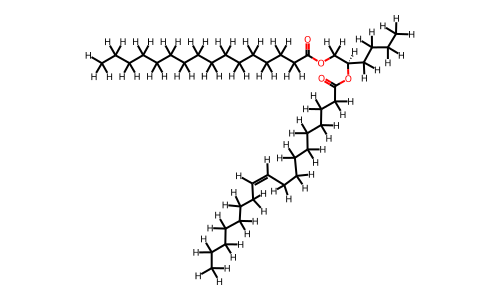

In [155]:
+

In [13]:
NAGLcharge = model.compute_property(lipid, check_domains = True, error_if_unsupported=True)
lipid.partial_charges  = NAGLcharge * unit.elementary_charge #openFF units attached to partial charges property

lipid.name = "POPE"
for i, atom in enumerate(lipid.atoms, 0):
    atom.metadata["residue_name"] = "POPE"
lipid.generate_unique_atom_names() 
topology = Topology.from_molecules([lipid])

forcefield = ForceField("openff-2.1.0.offxml")

interchange = Interchange.from_smirnoff(
    force_field=forcefield,
    topology=topology,
    charge_from_molecules = [lipid]
)
interchange

lipid.to_file('lipid.pdb', file_format = 'pdb')
interchange.to_top("lipid.top")
interchange.to_gro("lipid.gro")

/home/julianne/miniconda3/envs/openff/lib/python3.11/site-packages/openff/interchange/interop/gromacs/export/_export.py:48: UserWarning: WARNING: System defined with no box vectors, which GROMACS does not offically support in versions 2020 or newer (see https://gitlab.com/gromacs/gromacs/-/issues/3526). Setting box vectors to a 5  nm cube.
  self._write_gro(gro, decimal)


Visualize lipid with nglview

In [15]:
model_path = '/home/julianne/Desktop/OpenFFLipid/POPS/lipid.pdb' #change model path

view = nglview.show_structure_file(model_path)
view
#check that angles are all acceptable for POPE

NGLWidget()

If the lipid created is not in an optimal configuration for packing into a bilayer (e.g. tails are splayed), it may be necessary to pull the lipid to strighten it out. If the lipid is already in an okay configuration to pack, skip gmx pull command. 

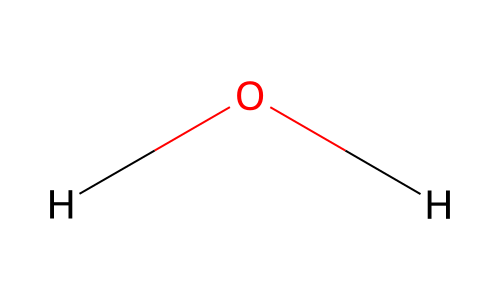

In [16]:
water = Molecule.from_smiles("O")
water.generate_conformers()
water.visualize()

In [17]:
NAGLcharge = model.compute_property(water, check_domains = True, error_if_unsupported=True)
water.partial_charges  = NAGLcharge * unit.elementary_charge

water.name = "TIP3P"

for i, atom in enumerate(water.atoms, 3):
    atom.metadata["residue_name"] = "TIP3P"
water.generate_unique_atom_names() 
topology = Topology.from_molecules([water])


interchange = Interchange.from_smirnoff(
    force_field=forcefield,
    topology=topology,
    charge_from_molecules = [water]
)
interchange

# PDB structure for Packmol
interchange.to_pdb("water.pdb")
interchange.to_top("water.top")

If the lipid is not in a propper configuration, running a pull script to straighten lipid out is necessary. 

First, create an index group for an atom in the lipid headgroup

In [ ]:
# The nitrogen from POPC is used here since it is the furthest core atom
# For more complicated structures, you can specificy multiple atoms and link them (reference 'specific_pull.mdp' in this repo)

$ gmx make_ndx -f lipid.gro -o N1x.ndx

# Input for this index
$ a 48 # Warning: check index in lipid.gro file to make sure that the index is correct.
$ name 3 N1x # Creates an atom group (3) with your selected atom
$ q

#this will create a file, 'N1x.ndx'

Run the pulling simulation in gromacs to straighten out the lipid. This script grabs the atom in the index file, and pulls it in the z direction.


In [ ]:
$ gmx grompp -f pull_nvt.mdp -c lipid.gro -p lipid.top -n A48.ndx -o pull.tpr -maxwarn 1 # Warning: Update pull_nvt.mdp with atom name
$ gmx mdrun -deffnm pull

### Use trjconv to produce a pdb of the lipid after pull code. Visualize with nglview to confirm 


In [ ]:
$ gmx trjconv -f pull.xtc -s pull.tpr -pbc mol -o POPE.pdb -dump 50 # Where '50' is the best frame
$ 0
#Please note that choosing the last frame may retult in distorted hydrogen bonding when visualizing below. 
# If this problem occurs choose an earlier frame

# If the GRO output is good enough at the end, use this:
$ gmx editconf -f pull.gro -o POPC.pdb

In [27]:
#visualize the pulled lipid using ngl view

model_path = '/home/julianne/Desktop/OpenFFLipid/POPS/POPS.pdb' #change model path

view = nglview.show_structure_file(model_path)
view


NGLWidget()

### Run packmol with the dumped PDB
You may have to modify the .inp structure file in packmol to fit your "pulled" lipid. Use MDAnalysis below to caluclate distance parameters based on your lipid for packing 

In [33]:
u = mda.Universe('POPE.pdb')

head_group = u.select_atoms('name N1x') #select atom in head group, in this case Nitrogen
tail_group = u.select_atoms('name C28x') #select atom in tail group, in this case last carbon in unsaturated tail

distance = distances.distance_array(head_group.positions,tail_group.positions)
print("Length of lipid from head group to tail group is:\n","~",round(distance[0][0],2),'Angstrom') 
#this will tell you the full length of your lipid 


Length of lipid from head group to tail group is:
 ~ 30.1 Angstrom


Estimate the desired number of lipids or membrane size in x y diresction when area per lipid is roughly known \
$ N_I = \frac{2 L_x L_y}{a_I}$  \
where $N_I$ = total # lipids\
$L_x , L_y$ = lateral box dimensions\
$a_I$ = area per lipid in units $Å^{2}$

In [34]:
# POPC ~ 65 Å^2
#For a square box:
N = 128
a = 65
L = np.sqrt(N * a /2)
print(round(L,1), "angstrom dimensions for Length")

64.5 angstrom dimensions for Length


In [ ]:
#modify .inp file if necessary with propper length and atom names 
$ packmol < bilayer-comment.inp
#if you have errors after running packmol make your box bigger 
# this returns a bilayer.pdb file that can be visualized below 

In [3]:
model_path = '/home/julianne/Desktop/Run_feb8/Compressed/bilayer.pdb' #change model path

view = nglview.show_structure_file(model_path)
view

NGLWidget()

### Build topology file from system interchange and get .gro file from .pdb

In [ ]:
$ cp POPC.top topol.top
$ cp POPC.top POPC.itp
$ cp water.top TIP3P.itp
# delete defaults, atom types, and molecules tables from .itp files
# remove all force field parameters from topol.top, add TIP3P atom types, changes molecules:
# [ molecules ]
# ; Compound	#mols
# TIP3P  	        5120  
# POPC  	         128

#Convert pdb into .gro file
$ gmx editconf -f bilayer.pdb -o bilayer.gro -box 7.5 7.5 8.0

Files are now ready to be run using Gromacs.

Min, NVT, NPT, MD production run

In [ ]:
$ gmx grompp -f min.mdp -p topol.top -c bilayer.gro -o min.tpr
$ gmx mdrun -deffnm min

$ gmx grompp -p topol.top -f nvt.mdp -c min.gro -o nvt.tpr
$ gmx mdrun -deffnm nvt

$ gmx grompp -f npt.mdp -p topol.top -c nvt.gro -o npt.tpr -maxwarn 1
$ gmx mdrun -deffnm npt

$ gmx grompp -f md.mdp -c npt.gro -t npt.cpt -p topol.top -o md.tpr
$ gmx mdrun -deffnm md
# Checkpoint run for completion
$ gmx mdrun -deffnm md -cpi md.cpt